# PCB Thermography Analysis Program
### Objective
This program is designed to process PCB thermography images (`.tif`). The workflow involves:
1. Correction image for a certain temperature, called "correction_TXXX". 
2. Loading and displaying the thermography image.

To achieve this, the internal procedure for any image will be:
1. Selecting and centering the PCB by defining the corners.
2. Defining an emissivity matrix for the PCB.
3. Calibrating the image based on emissivity and temperature data.

---


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
File correction_T296.npy found in folder T296. Proceeding with correction logic.


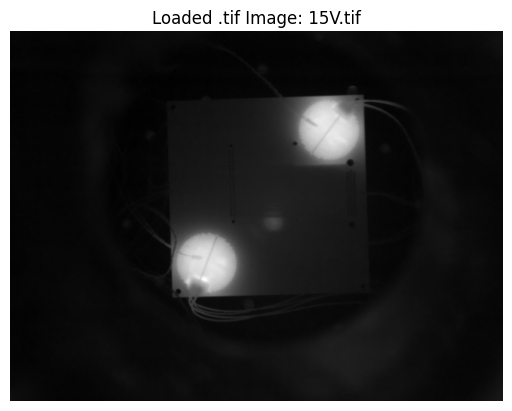

Image 15V.tif loaded and displayed successfully.


In [6]:
# Import necessary modules for automatic reloading of modified modules
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import tifffile as tiff
from tifffile import imread


# Import custom image processing functions
from image_processing import load_and_display_image, select_corners_jpg, select_corners_tif, matrix_resized
import emissivity_processing as ep

# Step 1: Ask the user for the test temperature in Kelvin
while True:
    try:
        temperature = float(input("What is the test temperature in Kelvin? "))
        if temperature <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number.")

# Step 2: Construct the folder and file name
temperature_int = int(round(temperature))
folder_name = f"T{temperature_int}"
file_name = f"correction_T{temperature_int}.npy"
file_path = os.path.join(folder_name, file_name)

# Para la toma de decisiones
correction_found = os.path.exists(file_path)

# Step 3: Check if the file exists and act accordingly
if correction_found:
    print(f"File {file_name} found in folder {folder_name}. Proceeding with correction logic.")
    correction_file = np.load(file_path)

    # Ask the user to input the image file name (with extension)
    image_name = input("Please enter the image name with extension (e.g., image.tif): ")

else:
    print(f"No correction file found for T={temperature_int} K. Running fallback routine.")

    # Ask the user to input the correction image file name (with extension)
    image_name = input("Please enter the correction image name with extension (e.g., image.tif): ")

image = load_and_display_image(image_name, temperature)

# Check if the image was loaded successfully
if image is not None:
    print(f"Image {image_name} loaded and displayed successfully.")
else:
    print(f"Failed to load the image {image_name}.")

# Extract the radiometric data, in K

image_path = os.path.join(folder_name, image_name)
image_data = tiff.imread(image_path)

## Processing the image

Selección de corners y resize a condiciones estándar: (500, 500) en continuo o 20x20 en discreto.

Temporary PNG saved at: T296\temp_corner_selection.png
Select 4 corners of the PCB by clicking on the image.
Corners selected: [(205, 91), (462, 81), (467, 342), (209, 344)]


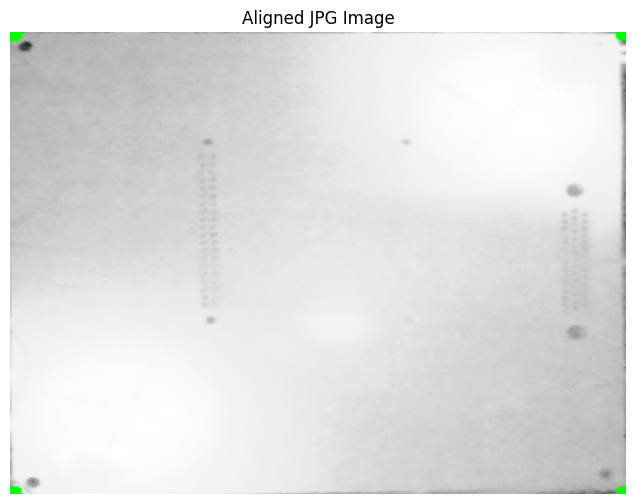

TIF image aligned and transformed.


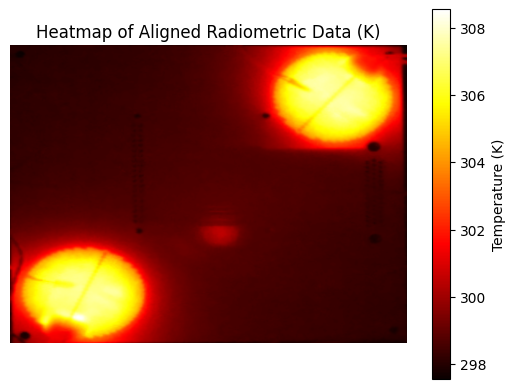

In [7]:
# Check the image extension (.jpg/.png or .tif)
extension = image_name.split('.')[-1].lower()

# Flag to indicate if processing a .tif file
is_tif = False

if extension in ['jpg', 'png']:
    # If the file is .jpg or .png, select corners, align the image, and calculate the RGB temperature matrix
    aligned_image_jpg, temperature_matrix_jpg, corners = select_corners_jpg(cv2.imread(image_path))
    
    # Print a portion of the RGB matrix to ensure it's not grayscale
    print("Sample of the RGB temperature matrix from the JPG image:")
    print(temperature_matrix_jpg[:5, :5, :])  # Print the first 5x5 elements of the RGB matrix

elif extension == 'tif':
    # If the file is .tif, set the flag to skip RGB processing
    is_tif = True

    # Generate a temporary .jpg for corner selection
    tif_data = imread(image_path)
    aligned_visual_tif, aligned_radiometric_data = select_corners_tif(tif_data=tif_data, temperature=temperature)

    print("TIF image aligned and transformed.")

    # Display the heatmap of the radiometric data with a proper temperature scale
    plt.imshow(aligned_radiometric_data, cmap='hot')
    plt.colorbar(label="Temperature (K)")
    plt.title("Heatmap of Aligned Radiometric Data (K)")
    plt.axis('off')
    plt.show()

else:
    # Notify the user if the file format is unsupported
    print("Unsupported file format. Only .jpg, .png, and .tif are supported.")


## Calibrating emissivity


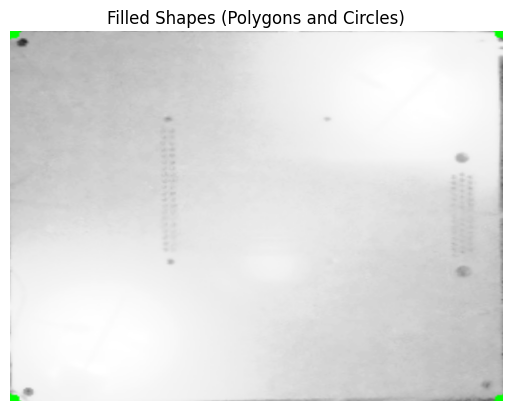

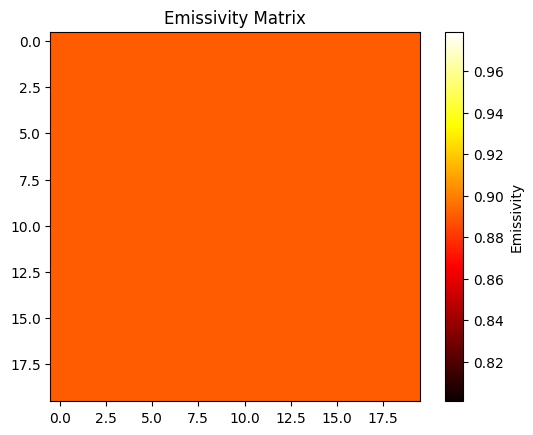


Emissivity information for defined shapes:


In [8]:
# Ask the user for the base emissivity value
base_emissivity = float(input("Enter the base emissivity value for the PCB: "))

# Process emissivity based on the image type
if extension in ['jpg', 'png']:
    emissivity_matrix = ep.process_emissivity(aligned_image_jpg, base_emissivity)
elif extension == 'tif':
    emissivity_matrix = ep.process_emissivity(aligned_visual_tif, base_emissivity)

emissivity_continuous, emissivity_discrete = matrix_resized(emissivity_matrix)

# Radiation Correction

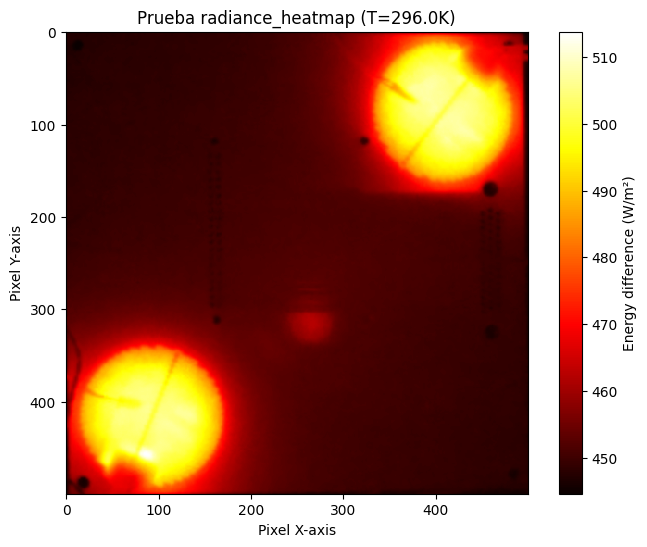

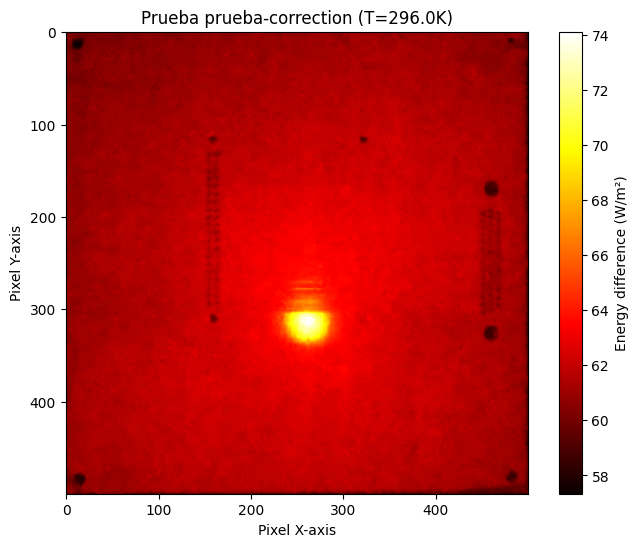

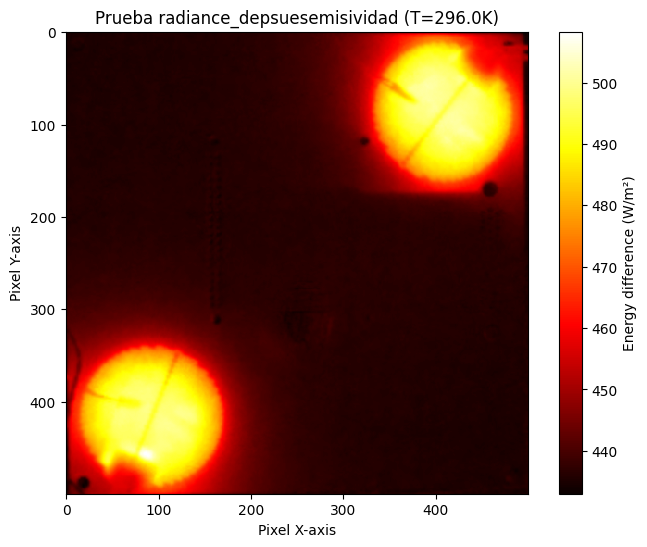

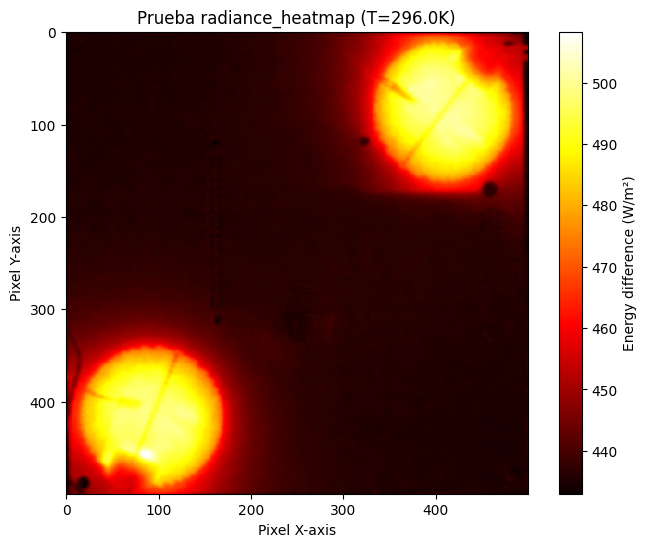

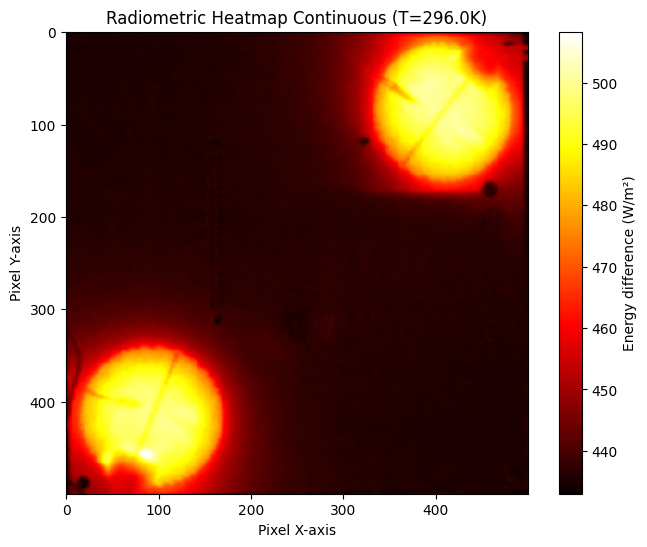

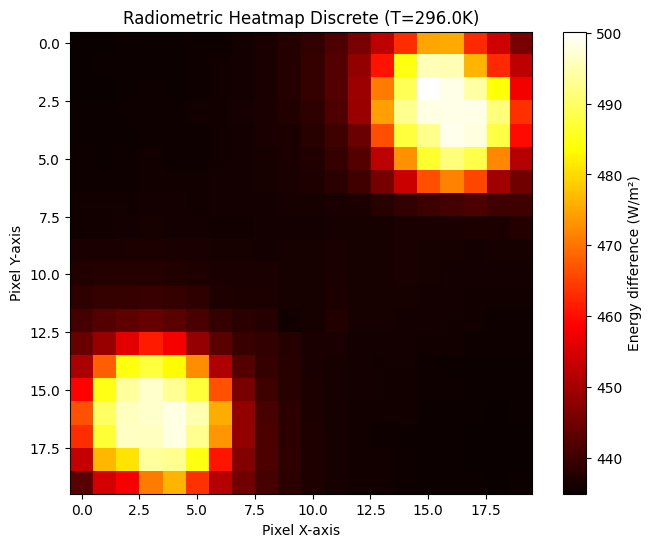

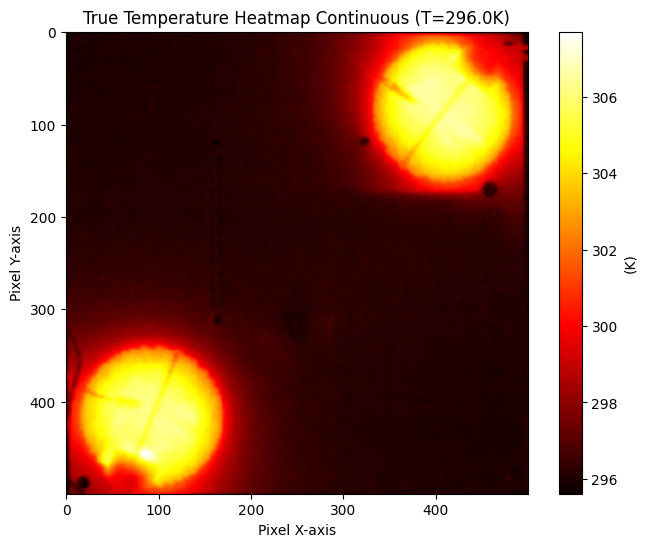

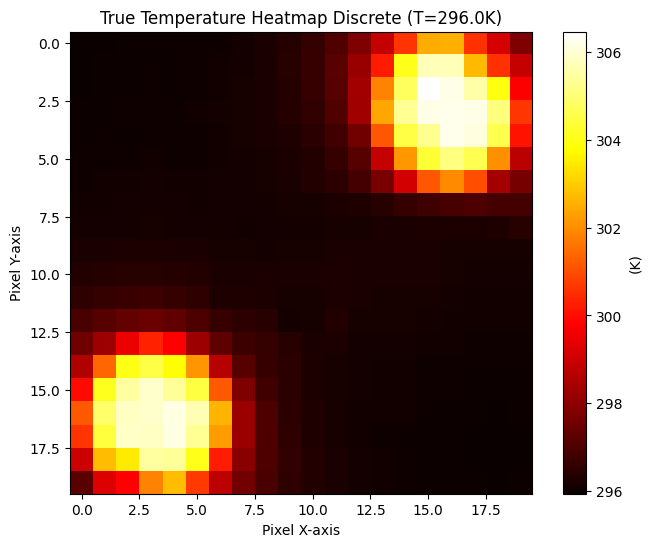

In [11]:
# Toma de decisión
from radiation_correction import final_image, correction_image

if correction_found:
    final_image(temperature, aligned_radiometric_data, correction_file, emissivity_matrix)
else:
    correction_image(temperature, aligned_radiometric_data, emissivity_matrix)

## Conclusion

In this notebook, we successfully loaded and processed thermal images in both .jpg and .tif formats. We applied corner selection, image alignment, emissivity calibration, and temperature matrix visualization. This workflow provides an efficient method to analyze thermographic data with proper calibration and visualization tools.